# Kalman Higher Order Solver
$$
% macros
% bold letters
\newcommand{\s}{\sigma}
\renewcommand{\aa}{{\boldsymbol a}}
\newcommand{\bb}{{\boldsymbol b}}
\newcommand{\cc}{{\boldsymbol c}}
\newcommand{\mm}{{\boldsymbol m}}
\newcommand{\ee}{{\boldsymbol e}}
\newcommand{\uu}{{\boldsymbol u}}
\newcommand{\hh}{{\boldsymbol h}}
\newcommand{\yy}{{\boldsymbol y}}
\newcommand{\xx}{{\boldsymbol x}}
\newcommand{\vv}{{\boldsymbol v}}
\renewcommand{\AA}{{\boldsymbol A}}
\newcommand{\BB}{{\boldsymbol B}}
\newcommand{\CC}{{\boldsymbol C}}
\newcommand{\DD}{{\boldsymbol D}}
\newcommand{\FF}{{\boldsymbol F}}
\newcommand{\LL}{{\boldsymbol L}}
\newcommand{\QQ}{{\boldsymbol Q}}
\newcommand{\VV}{{\boldsymbol V}}
\newcommand{\WW}{{\boldsymbol W}}
\newcommand{\XX}{{\boldsymbol X}}
\newcommand{\YY}{{\boldsymbol Y}}
\newcommand{\ZZ}{{\boldsymbol Z}}
\newcommand{\VVb}{{\overline{\boldsymbol V}_{\infty}}}
% bold symbols
\newcommand{\eps}{{\boldsymbol \epsilon}}
\newcommand{\eet}{{\boldsymbol \eta}}
\newcommand{\rrh}{{\boldsymbol \rho}}
\newcommand{\tth}{{\boldsymbol \theta}}
\newcommand{\lla}{{\boldsymbol \lambda}}
\newcommand{\mmu}{{\boldsymbol \mu}}
\newcommand{\ssi}{{\boldsymbol \sigma}}
\newcommand{\LLa}{{\boldsymbol \Lambda}}
\newcommand{\GGa}{{\boldsymbol \Gamma}}
\newcommand{\PPs}{{\boldsymbol \Psi}}
\newcommand{\SSi}{{\boldsymbol \Sigma}}
\newcommand{\bz}{{\boldsymbol 0}}
\newcommand{\Id}{{\boldsymbol I}}
\newcommand{\vi}{v^\star}
\newcommand{\vvi}{\boldsymbol{v^\star}}
\newcommand{\pkg}[1]{\textbf{#1}}
\newcommand{\llab}{{\bar{\boldsymbol \lambda}}}
\newcommand{\ui}{u^\star}
\newcommand{\uui}{\boldsymbol{u^\star}}
% other math
\DeclareMathOperator{\bigO}{\mathcal O}
\let\vec\relax
\DeclareMathOperator{\vec}{vec}
\newcommand{\ud}{\, \mathrm{d}}
\newcommand{\iid}{\stackrel{iid}{\sim}}
\let\sp=^
\DeclareMathOperator{\var}{var}
\DeclareMathOperator{\cov}{cov}
\newcommand{\rv}[3][1]{#2_{#1},\ldots,#2_{#3}}
\newcommand{\lp}[1]{_{(#1)}}
\newcommand{\N}{\mathcal N}
\DeclareMathOperator{\car}{CAR}
\newcommand{\correct}[1]{[{\color{red}#1}]}
$$

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

//Enable equation numbering

<IPython.core.display.Javascript object>

## The Continuous-Time Autoregressive Process

The (mean-zero) Multivariate Ornstein-Uhlenbeck (mOU) process $\XX_t = \XX(t) = (\rv [1t] X {dt})$is of the form
\begin{equation}\label{eq:mou}
\ud \XX_{t} = -\GGa \XX_{t} \ud t + \SSi^{1/2} \ud \BB_t,
\end{equation}
where $\GGa_{d\times d} = \QQ\DD\QQ^{-1}$,
$\SSi_{d\times d}$ is a variance matrix, and $\BB_t = (\rv [1t] B {pt})$ are iid Brownian motions.

A univariate process $Z_t$ is said to be $\car(p)$ if it satisfies the equation
\begin{equation}
  \label{eq:car}
  Z_t\sp{p} + \alpha_1 Z_t\sp{p-1} + \cdots + \alpha_{p-1} Z_t\sp{1} + \alpha_p Z_t = \s B_t\sp 1,
\end{equation}
where superscripts denote derivative order.  This process admits $p-1$ continuous derivatives, and in fact can be described by the $p$-dimensional mOU process~\eqref{eq:mou} with $\XX_t = (Z_t, Z_t\sp 1, \ldots, Z_t\sp{p-1})$ and
$$
  \GGa = \begin{bmatrix}
    0 & -1 & \cdots & 0 \\
    0 & 0 & \cdots & 0 \\
    \vdots & & & \\
    0 & 0 & \cdots & -1 \\
    \alpha_p & \alpha_{p-1} & \cdots & \alpha_1
  \end{bmatrix}, \qquad \SSi^{1/2} = \begin{bmatrix}
    0 & 0 & \cdots & 0 \\
    0 & 0 & \cdots & 0 \\
    \vdots & & & \\
    0 & 0 & \cdots & 0 \\
    0 & 0 & \cdots & \sigma
  \end{bmatrix}.
$$
Consider the $p$th order polynomial
\begin{equation}\label{eq:carpoly}
  \alpha(s) = s^p + \alpha_1s^{p-1} + \cdots + \alpha_{p-1} s + \alpha_p = \prod_{k=1}^p (s - r_k).
\end{equation}
Then the diagonalization $\GGa = \QQ\DD\QQ^{-1}$ has terms $\DD = diag(\rv {-r} p)$ and
\begin{equation}\label{eq:careig}
  \QQ = \begin{bmatrix}
    1 & 1 & \cdots & 1 \\
    r_1 & r_2 & \cdots & r_p \\
    \vdots & & & \\
    r_1^{p-1} & r_2^{p-1} & \cdots & r_p^{p-1}
  \end{bmatrix}.
\end{equation}

## Kalman ODE Algorithm 

### Setup 

Let $x(t)$ be a $q$ times continuously differentiable function satisfying the higher-order ODE
\begin{equation}
  \label{eq:ode}
  \aa'\XX(t) = f(\XX(t), t) = 0, \qquad t \in [0, T], \qquad \XX(0) = \cc,
\end{equation}
where $\XX(t) = \big(x^{(0)}(t), x^{(1)}(t), \ldots, x^{(q)}(t)\big)$.
The goal is to approximate the ODE at time points $t_n = nT/N$ for $n = 0,\ldots,N$.  To do this, the Bayesian ODE solver begins with a Gaussian process prior distribution on $\XX(t)$, and updates the distribution of $\XX(t)$ based on noisy observations -- or \emph{interrogations} -- which shall be defined momentarily.  The prior distribution we consider is
\begin{equation}
  \label{eq:prior}
  \YY(t) = \big(\XX(t), \ZZ(t)\big) \sim \car_p(\lla, \rrh, \sigma),
\end{equation}
where $\YY(t) = \big(x(t), x^{(1)}(t), \ldots, x^{(p-1)}(t)\big)$ is a $p-1$ times differentiable process, $p>q$, and $\car_p(\rrh, \sigma)$ denotes a continuous autoregressive process with mean $\lla = (\rv \lambda p)$, roots $\rrh = (\rv \rho p)$ and scale parameter $\sigma > 0$.  Let $\YY_n = (x^{(0)}_n, \ldots, x^{(p-1)}_n)$ be shorthand for $\YY(t_n) = \big(x^{(0)}(t_n), \ldots, x^{(p-1)}(t_n)\big)$, and similarly for $\XX_n$ and $\ZZ_n$.  Then we have
\begin{equation}
  \label{eq:markov}
    \YY_n = \AA \YY_{n-1} + \bb + \CC \eps_n,
\end{equation}
where $\bb = \lla - \AA\lla$ and $\eps_n \iid \N(\bz, \Id_p)$.  For stationary CAR processes, we have the initial condition $\YY_0 \sim \N(\lla, \VV_{\infty})$.


### Bayesian ODE Solution
The procedure below produces a stochastic sequence of variables $\rv [0] \YY N$ that contains $\rv [0] \XX N$ which converges to the true ODE solution as $N \to \infty$. The algorithm sequentially generates a sequence of model interrogations $\rv [0] {\ui} N$, where $\ui_n$ is a noisy realization of $u_n = \aa'\XX_n$.  Then, it updates the solution prior with the information provided by $\uui_{0:n}$.

First consider the process of choosing $\ZZ_0$ given $\XX_0 = \cc$ using the matrix decomposition
$$
  \lla = \begin{bmatrix} \lla\sp {X} \\ \lla\sp {Z} \end{bmatrix}, \qquad \VV_{\infty} = \begin{bmatrix} \VV_{\infty}\sp {XX} & \VV_{\infty}\sp {XZ} \\ \VV_{\infty}\sp {ZX} & \VV_{\infty}\sp {ZZ} \end{bmatrix}.
$$

Using the multivariate normal conditional formula to find the mean and variance of the conditional distribution $p(\ZZ_0 \mid \XX_0 = \cc) \sim \N(\llab, \VVb)$, where 
  \begin{align*}
    \llab & = \lla\sp {Z} + \VV_{\infty}\sp {ZX} [\VV_{\infty}\sp{XX }]^{-1}(c - \lla\sp {X})  \\
    \VVb & = \VV_{\infty}\sp {ZZ} - \VV_{\infty}\sp {ZX} [\VV_{\infty}\sp {XX}]^{-1} \VV_{\infty}\sp {XZ}.
  \end{align*}

Let $\mmu_{n|m}$ and $\SSi_{n|m}$ correspond to the mean and variance of $p(\YY_n \mid \uui_{0:m})$.

**Base Case.**  At time $t_0 = 0$, we have the exact solution $\XX_0 = \cc$ and the initially drawn $\ZZ_0 \sim N(\llab, \VVb)$.  In this case, the model interrogation is noise-free, i.e., $u_0^\star = \aa'\cc$, $\mmu_{0|0} = \YY_0$ and $\SSi_{0|0} = \bz_{p\times p}$.

**Forward Steps.**  Suppose that we have calculated $\mmu_{n-1|n-1}$ and $\SSi_{n-1|n-1}$, the mean and variance of $p(\YY_{n-1} \mid \uui_{0:n-1})$.  Then our predictive distribution for $\YY_{n}$ given the current information is
$$
    \YY_{n} \mid \uui_{0:n-1} \sim \N(\mmu_{n|n-1}, \SSi_{n|n-1}),
$$
  where
  \begin{align*}
    \mmu_{n|n-1} & = E[E[\YY_{n} \mid \YY_{n-1}, \uui_{0:n-1}] \mid \uui_{0:n-1}] \\
                 & = \AA \mmu_{n-1|n-1} + \bb \\
    \SSi_{n|n-1} & = \var(E[\YY_{n} \mid \YY_{n-1}, \uui_{0:n-1}] \mid \uui_{0:n-1}) + E[\var(\YY_{n} \mid \YY_{n-1}, \uui_{0:n-1}) \mid \uui_{0:n-1}] \\
                 & = \AA\SSi_{n-1|n-1}\AA' + \CC\CC'.
  \end{align*}
  The interative step then proceeds in two parts:
  
  i. *Model Interrogation.* The variable $\ui_{n}$ is generated as follows:
    \begin{align*}
      \YY_n^\star & \sim \N(\mmu_{n|n-1}, \SSi_{n|n-1}) \implies \YY_n^\star = \mmu_{n|n-1} + \DD \rrh_n\\ 
      \ui_n & = f(\XX_n^\star, t_n),
    \end{align*}
    where $t_n = nT/N$, $\DD$ is the cholesky decomposition of $\SSi_{n|n-1}$ and  $\rrh_n \iid \N(\bz_{p}, \Id_{p})$.
    
  ii. *Update.* The mean and variance $\mmu_{n|n}$ and $\SSi_{n|n}$ of $p(\YY_n \mid \uui_{0:n})$ are then calculated using the usual Kalman filter equations for the state space model
    \begin{equation}
      \begin{aligned}
        \YY_n & = \AA \YY_{n-1} + \bb + \CC \eps_n \\
        \ui_n & = \aa'\YY_n + \s_n \eta_n,
      \end{aligned}
      \label{eq:kfwd}
    \end{equation}
    where $\s_n^2 = \aa_\star'\SSi_{n|n-1}\aa_\star$ and $\eta_n \iid \N(0,1)$ is independent of $\eps_{0:N}$.  The first line in \eqref{eq:kfwd} is recognized as the Markov process for the prior, whereas the second line specifies how the noisy interrogation $\ui_n$ is related to $u_n$.

**Smoothing Step.**  Now that we have calculated $\uui_{0:N}$ and $\ssi_{0:N}$, apply the Kalman smoother to obtain the mean and variance of $p(\YY_n \mid \uui_{0:N})$ for each $n = 0,\ldots,N$. Then the mean and variance of $p(\XX_n \mid \uui_{0:N})$ can be obtained from $p(\YY_n \mid \uui_{0:N})$ to approximate the ODE solution.


In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
import BayesODE as bo
from BayesODE import var_car, cov_car
from BayesODE.Tests.root_gen import root_gen
from BayesODE.Tests.V_euler import V_euler
from BayesODE.utils import mvCond
from BayesODE._mou_car import _mou_car
from BayesODE.kalman_initial_draw import kalman_initial_draw
from BayesODE.kalman_ode_higher import kalman_ode_higher
from BayesODE.higher_mvCond import higher_mvCond
from BayesODE.Tests.test_exp_integrate import cov_yy_ex

## Example (6) in Chkrebtii Paper

As a simple example, consider the second order initial value ODE problem,

$$
\begin{align*}
x^{(2)}(t) &= sin(2t) − x, \quad t ∈ [0, 10], \\
x^{(1)}(0) &= 0, \quad x(0) = −1. 
\end{align*}
$$


Its exact solution, $x^{\star}(t) = \frac{−3 cos(t) + 2 sin(t) − sin(2t)}{3}$

In [3]:
from math import sin, cos
def chk_F(y_t, t):
    return sin(2*t) - y_t[0] #X^{2} = sing(2t) - X

def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [4]:
N = 100
q = 2
p = q+2

delta_t = np.array([1/N])
r0 = 0.5
sigma = 0.001
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([0,0,1])
x0 = np.array([-1,0,0])
x0 = np.array([-1,0,chk_F(x0, 0)]) #Initial state

Y0 = kalman_initial_draw(roots, sigma, x0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 
b = np.zeros(p)

Yn_chk_mean, Yn_chk_var = kalman_ode_higher(chk_F, Y0, N-1, A, b, V, a)

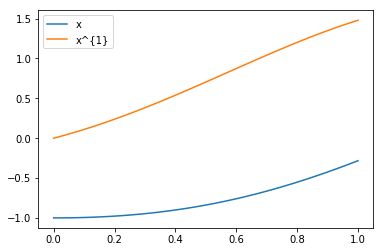

In [5]:
N = 100
tseq = np.linspace(0,1,N)
exact_chk_x = np.zeros(N)
exact_chk_x1 = np.zeros(N)
for t in range(N):
    exact_chk_x[t] = chk_exact_x(tseq[t])
    exact_chk_x1[t] = chk_exact_x1(tseq[t])
plt.plot(tseq,exact_chk_x,label='x')
plt.plot(tseq,exact_chk_x1,label='x^{1}')
plt.legend(loc='upper left')

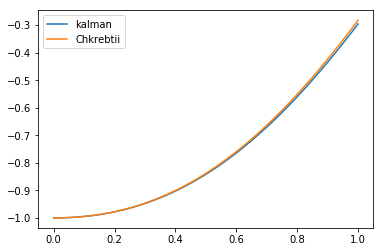

In [6]:
kalman_chk_x = Yn_chk_mean[:,0]
plt.plot(tseq,kalman_chk_x, label = 'kalman')
plt.plot(tseq,exact_chk_x, label = 'Chkrebtii')
plt.legend(loc='upper left')

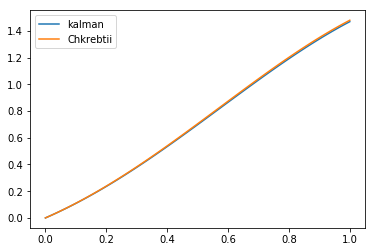

In [7]:
kalman_chk_x1 = Yn_chk_mean[:,1]
plt.plot(tseq,kalman_chk_x1, label = 'kalman')
plt.plot(tseq,exact_chk_x1, label = 'Chkrebtii')
plt.legend(loc='upper left')

## Textbook example 2 in 3.1

In [8]:
from math import exp

def text_F(y_t, t):
    return 4*y_t[0] + 12*t

def text_exact_x(t):
    return 3*exp(2*t) + exp(-2*t) -3*t

def text_exact_x1(t):
    return 6*exp(2*t)-2*exp(-2*t)-3


In [9]:
N = 100
q = 2
p = q+2

delta_t = np.array([1/N])
r0 = 0.5
sigma = 0.001
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([0,0,1])
x0 = np.array([4,1,0])
x0 = np.array([4,1,text_F(x0, 0)]) #Initial state

Y0 = kalman_initial_draw(roots, sigma, x0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 
b = np.zeros(p)

Yn_text_mean, Yn_text_var = kalman_ode_higher(text_F, Y0, N-1, A, b, V, a)

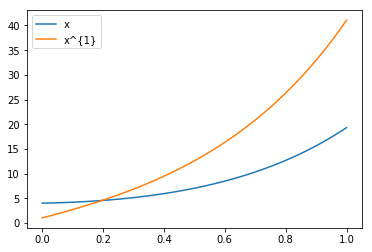

In [10]:
N = 100
tseq = np.linspace(0,1,N)
exact_text_x = np.zeros(N)
exact_text_x1 = np.zeros(N)
for t in range(N):
    exact_text_x[t] = text_exact_x(tseq[t])
    exact_text_x1[t] = text_exact_x1(tseq[t])
plt.plot(tseq,exact_text_x,label='x')
plt.plot(tseq,exact_text_x1,label='x^{1}')
plt.legend(loc='upper left')

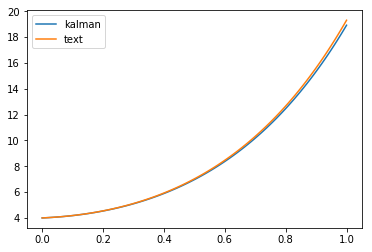

In [11]:
kalman_text_x = Yn_text_mean[:,0]
plt.plot(tseq,kalman_text_x, label= 'kalman')
plt.plot(tseq,exact_text_x, label = 'text')
plt.legend(loc='upper left')

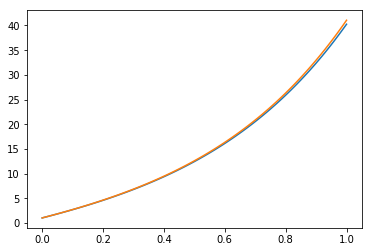

In [12]:
kalman_text_x1 = Yn_text_mean[:,1]
plt.plot(tseq,kalman_text_x1)
plt.plot(tseq,exact_text_x1)

## First Order ODE example

In [13]:
def first_F(y_t,t):
    return 3*(t+1/4) - y_t[0]/(t+1/4)

def f(y, t):
    return 3*(t+1/4) - y/(t+1/4)

In [ ]:
t0 = 0
tn = 1
x0 = 0
N = 100
tseq = np.linspace(t0, tn, N)
gamma = 1.67
alpha = 1000

Sigma_vv = bo.cov_vv_ex(tseq, tseq, gamma, alpha)
Sigma_xx = bo.cov_xx_ex(tseq, tseq, gamma, alpha)
Sigma_xv = bo.cov_xv_ex(tseq, tseq, gamma, alpha)
x_bayes,_,_ = bo.bayes_ode(f, tseq, x0, Sigma_vv, Sigma_xx, Sigma_xv)

In [ ]:
v_bayes = np.zeros(N)
for i in range(N):
    v_bayes[i] = f(x_bayes[i], tseq[i])
y_bayes = list(zip(x_bayes,v_bayes))

In [ ]:
gamma = 1.67
alpha = 1000
Sigma = cov_yy_ex(tseq[1:3], tseq[1:3], gamma, alpha)
icond = np.array([True]*2 + [False]*2)
mu = np.array([0, 0, 0, 0])
A, b, V = mvCond(mu, Sigma, icond)

In [ ]:
N = 100
q = 1
p = q+1

delta_t = np.array([1/N])
r0 = np.random.uniform()
r0 = 0.5
sigma = 0.0001
roots = root_gen(r0, p) 
a = np.array([0,1])
x0 = np.array([0,0])
x0 = np.array([0,first_F(x0,0)]) #Initial state
Y0 = kalman_initial_draw(roots, sigma, x0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 
b = np.zeros(p)

Yn_first_mean1, Yn_first_var1 = kalman_ode_higher(first_F, Y0, N-1, A, b, V, a)

In [ ]:
plt.plot(tseq,Yn_first_mean1[:,0], label='p=2; x')
plt.plot(tseq,x_bayes, label = 'bayes; x')
plt.legend(loc='upper left')

In [ ]:
plt.plot(tseq,Yn_first_mean1[:,1], label='p=2; x^{1}')
plt.plot(tseq,v_bayes, label = 'bayes; x^{1}')
plt.legend(loc='upper left')

In [ ]:
N = 100
q = 1
p = q+2

delta_t = np.array([1/N])
r0 = 0.5
sigma = 0.0001
roots = root_gen(r0, p)
a = np.array([0,1])
x0 = np.array([0,0])
x0 = np.array([0,first_F(x0,0)]) #Initial state
Y0 = kalman_initial_draw(roots, sigma, x0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 
b = np.zeros(p)

Yn_first_mean2, Yn_first_var2 = kalman_ode_higher(first_F, Y0, N-1, A, b, V, a)

In [ ]:
plt.plot(tseq,Yn_first_mean2[:,0], label='p=3; x')
plt.plot(tseq,x_bayes, label = 'bayes; x')
plt.legend(loc='upper left')

In [ ]:
plt.plot(tseq,Yn_first_mean2[:,1], label='p=3; x^{1}')
plt.plot(tseq,v_bayes, label = 'bayes; x^{1}')
plt.legend(loc='upper left')